## Imports and Preliminaries

In [1]:
%matplotlib inline
from typing import List, Optional, Callable, Iterator
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset
from scipy.spatial.distance import cosine
from difflib import SequenceMatcher
import torch
from urllib.request import urlopen
from PIL import Image
import timm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cuda


## Similarity Metric Functions

In [2]:
def euclidean_similarity(v1, v2):
    """Calculate similarity using Euclidean distance."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return 1 / (1 + np.linalg.norm(v1 - v2))

def cosine_sim(v1, v2):
    """Calculate cosine similarity."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return 1 - cosine(v1, v2)

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets or arrays."""
    a, b = np.asarray(set1).ravel(), np.asarray(set2).ravel()
    a, b = set(a.tolist()), set(b.tolist())
    intersection = len(a & b)
    union = len(a | b)
    return intersection / union if union != 0 else 0

def pearson_correlation(v1, v2):
    """Calculate Pearson correlation coefficient."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return np.corrcoef(v1, v2)[0, 1]

def string_similarity(str1, str2):
    """Calculate string similarity using SequenceMatcher."""
    str1, str2 = str(str1), str(str2)
    return SequenceMatcher(None, str1, str2).ratio()


## PCA tensor mapping

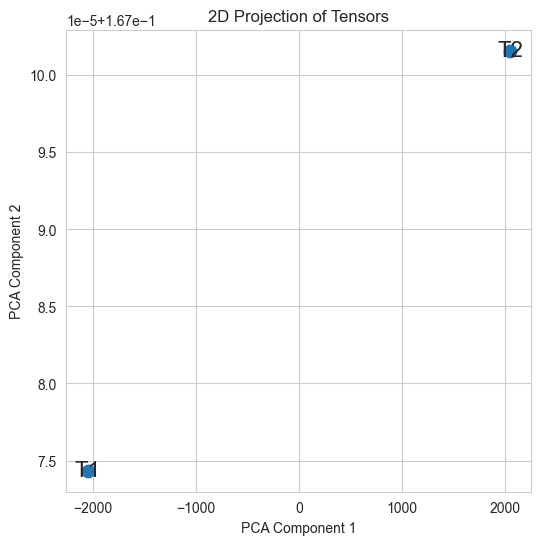

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_tensors_2d(*tensors):
    """
    Takes n tensors of arbitrary dimensionality, flattens them (removing batch dim if 1),
    reduces to 2D using PCA, and plots them on a 2D scatter plot.
    """
    flattened = []
    for t in tensors:
        arr = np.array(t)  # ensure NumPy array
        if arr.ndim > 1 and arr.shape[0] == 1:
            arr = np.squeeze(arr, axis=0)  # remove batch dim if it's 1
        flattened.append(arr.reshape(-1))

    data = np.stack(flattened)
    
    if data.shape[0] < 2:
        raise ValueError("Need at least 2 tensors to perform PCA (n_components=2).")
    
    reduced = PCA(n_components=2).fit_transform(data)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=80)
    for i, (x, y) in enumerate(reduced):
        plt.text(x, y, f"T{i+1}", fontsize=16, ha="center", va="center")
    plt.title("2D Projection of Tensors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()


a = torch.randn(128, 256, 256)
b = torch.randn(128, 256, 256)

plot_tensors_2d(a.numpy(), b.numpy())


## Dataset Class

In [4]:
from pathlib import Path
from PIL import Image
from torchvision import transforms

class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split='train', transform=None):
        """
        Args:
            root_dir: Path to MVTec AD dataset root
            category: Product category (e.g., 'bottle', 'cable', 'capsule')
            split: 'train' or 'test'
            transform: Preprocessing transforms
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        
        # Build image paths
        self.image_paths = []
        self.labels = []
        self.defect_types = []
        
        if split == 'train':
            # Training images are all normal
            train_dir = self.root_dir / category / 'train' / 'good'
            for img_path in sorted(train_dir.glob('*.png')):
                self.image_paths.append(img_path)
                self.labels.append(0)
                self.defect_types.append('good')
        else:
            # Test images include normal and anomalies
            test_dir = self.root_dir / category / 'test'
            for defect_dir in sorted(test_dir.iterdir()):
                if defect_dir.is_dir():
                    defect_type = defect_dir.name
                    label = 0 if defect_type == 'good' else 1
                    for img_path in sorted(defect_dir.glob('*.png')):
                        self.image_paths.append(img_path)
                        self.labels.append(label)
                        self.defect_types.append(defect_type)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.defect_types[idx]


## Create Datasets

In [5]:
from torch.utils.data import ConcatDataset

MVTEC_ROOT = './Dataset' 
BATCH_SIZE = 500
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ])


transform = get_transforms(IMAGE_SIZE)

all_categories = [
    'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut',
    'leather', 'metal_nut', 'pill', 'screw', 'tile',
    'toothbrush', 'transistor', 'wood', 'zipper'
]

train_datasets = [
    MVTecDataset(root_dir=MVTEC_ROOT, category=cat, split="train", transform=transform)
    for cat in all_categories
]

train_dataset = ConcatDataset(train_datasets)

test_datasets = [
    MVTecDataset(root_dir=MVTEC_ROOT, category=cat, split="test", transform=transform)
    for cat in all_categories
]

test_dataset = ConcatDataset(test_datasets)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

TRAINING IMAGES


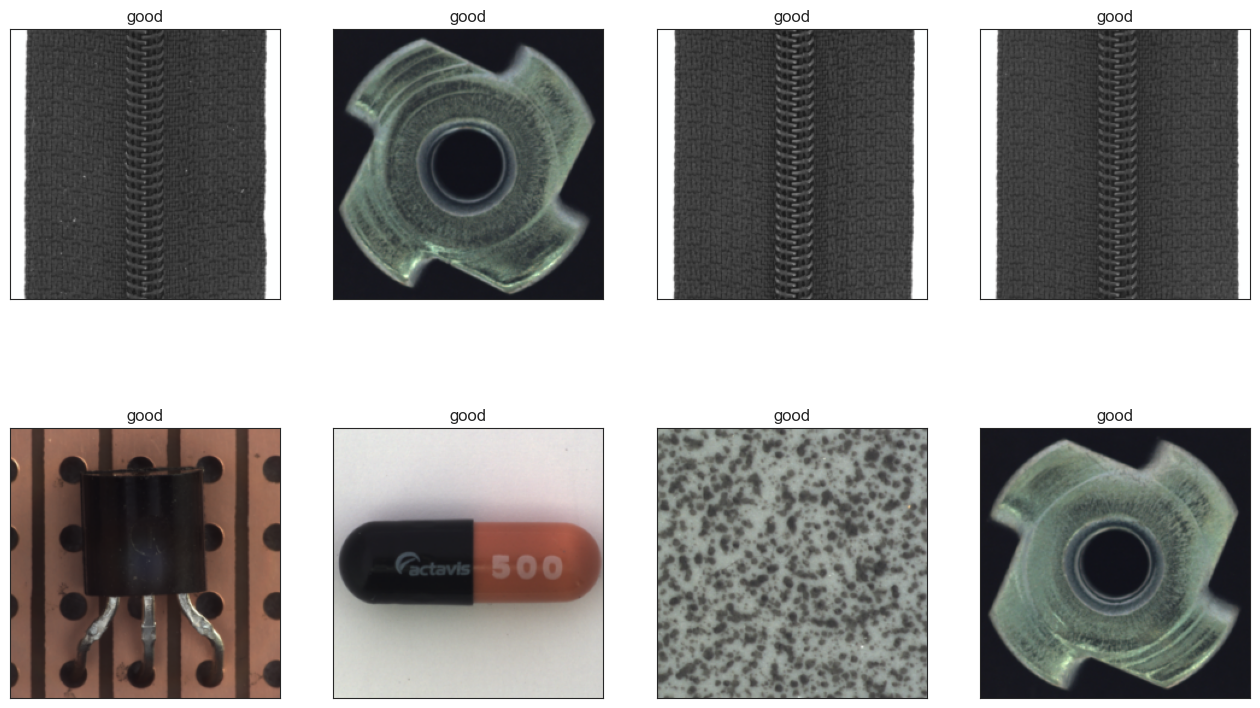

TESTING IMAGES


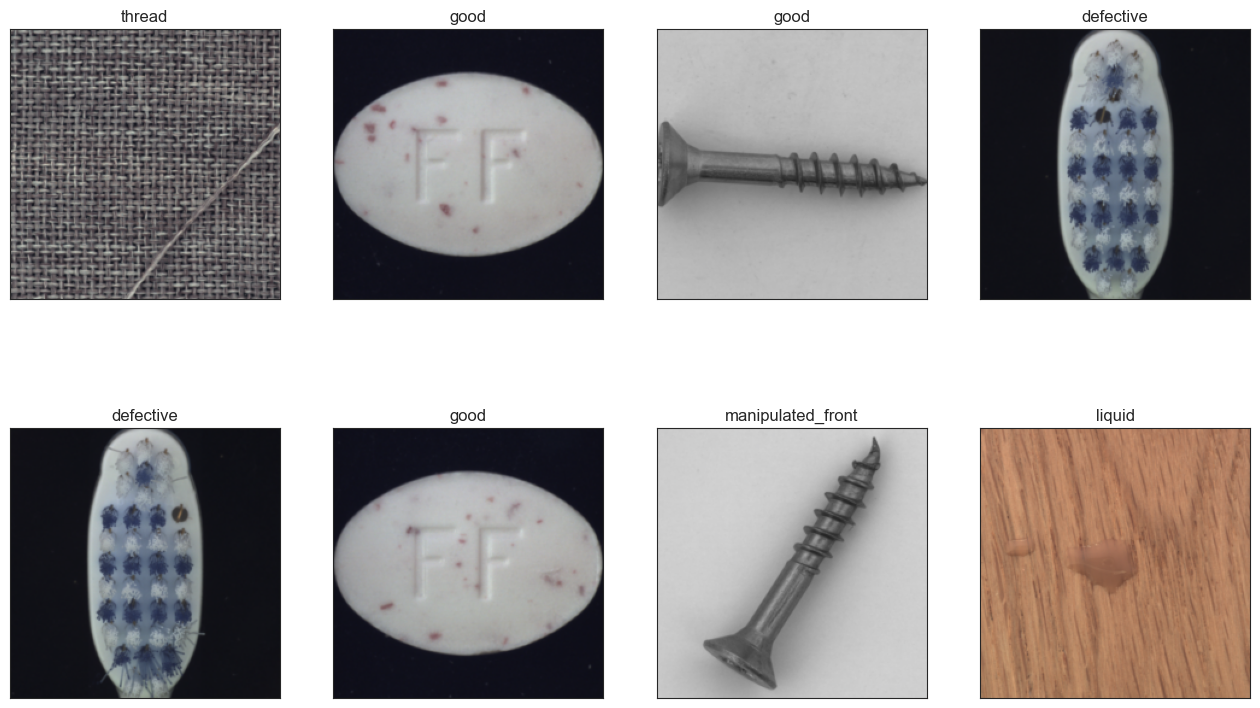

In [8]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
      fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten
    for j, (img, label) in enumerate(zip(images[:8], labels[:8])):
        plt.sca(axes[j])
        show_image(img, label)
    plt.show()

def show_dataset_all_labels(dataloader):
  images, labels = next(iter(dataloader))
  i = 0
  for j, (img, label) in enumerate(zip(images, labels)):
      print(f"{label} is image {i}")
      i+= 1

print("TRAINING IMAGES")
show_dataset_examples(train_loader)
print("TESTING IMAGES")
show_dataset_examples(test_loader)

## Add DINO using TIMM for Visualization

In [10]:
import torch
from urllib.request import urlopen
from PIL import Image
import timm
import torchvision.transforms as T

def embed_and_plot_from_loader(dataloader, max_images=8, model_url = "vit_small_patch16_dinov3_qkvb.lvd1689m"):
    # Load model
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    # Preprocessing (timm's eval pipeline) + tensor->PIL converter
    data_config = timm.data.resolve_model_data_config(model)
    preprocess = timm.data.create_transform(**data_config, is_training=False)
    to_pil = T.ToPILImage()

    # Take one batch from the loader
    images, _ = next(iter(dataloader))

    embeddings = []
    for img in images[:max_images]:
        # Ensure PIL for timm transforms
        if isinstance(img, torch.Tensor):
            img = to_pil(img)

        x = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            feats = model.forward_features(x)
            if isinstance(feats, dict):
                emb = feats.get('x_norm_clstoken') or feats.get('x_norm')
            else:
                emb = feats

        embeddings.append(emb.squeeze(0).cpu().numpy())

    # Plot
    if len(embeddings) >= 2:
        plot_tensors_2d(*embeddings)
    else:
        print("Need at least 2 images to plot.")


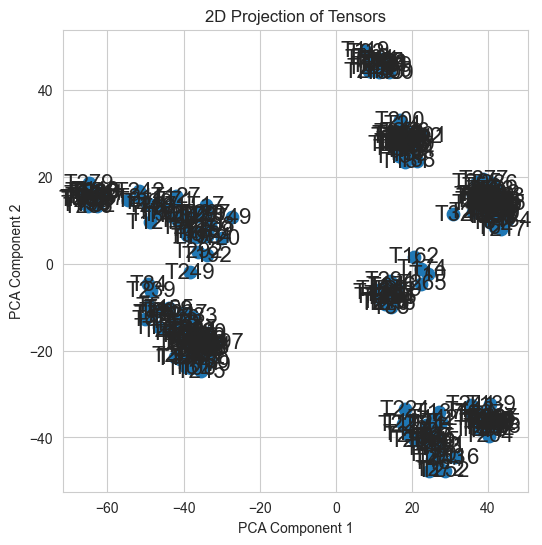

In [11]:
embed_and_plot_from_loader(train_loader, max_images=300)

## Embed training features, compare to Test data and draw conclusion

In [12]:
def embed_and_save_features(dataloader, model_url = "vit_small_patch16_dinov3_qkvb.lvd1689m"):
    # Load model
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    # Preprocessing (timm's eval pipeline) + tensor->PIL converter
    data_config = timm.data.resolve_model_data_config(model)
    preprocess = timm.data.create_transform(**data_config, is_training=False)
    to_pil = T.ToPILImage()

    # Take one batch from the loader
    images, labels = next(iter(dataloader))

    embeddings = []
    for (img, label) in zip(images, labels):
        # Ensure PIL for timm transforms
        if isinstance(img, torch.Tensor):
            img = to_pil(img)

        x = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            feats = model.forward_features(x)
            if isinstance(feats, dict):
                emb = feats.get('x_norm_clstoken') or feats.get('x_norm')
            else:
                emb = feats

        embeddings.append((emb.squeeze(0).cpu().numpy(), label))

    return embeddings



In [13]:
import numpy as np
import csv

def compare_similarities_vecs(test_vec, gt_vecs, sim_func):
    """Compute similarity between one test vector and many GT vectors."""
    tv = np.asarray(test_vec).ravel()
    sims = []
    for g in gt_vecs:
        gv = np.asarray(g).ravel()
        if tv.shape[0] != gv.shape[0]:
            raise ValueError(f"Dim mismatch: test D={tv.shape[0]} vs GT D={gv.shape[0]}")
        sims.append(sim_func(tv, gv))
    return np.array(sims)


def compare_and_draw_conclusion(threshold=0.8, rank=10, csv_path="results.csv"):
    """
    - Uses the `rank`-th best similarity (default: 10th).
    - Predicts 'good' if that similarity > threshold, else 'anomalous'.
    - Saves all test case results and final accuracy to a CSV file.
    """
    embeddings_GT = embed_and_save_features(train_loader)   # [(embedding, label), ...]
    embeddings_Test = embed_and_save_features(test_loader)

    gt_embeddings, _ = zip(*embeddings_GT) if len(embeddings_GT) else ([], [])

    results = []
    correct = 0
    total = 0

    for test_embedding, label in embeddings_Test:
        similarities = compare_similarities_vecs(test_embedding, gt_embeddings, cosine_sim)
        sorted_sims = np.sort(similarities)[::-1]  # descending order

        # Pick the rank-th best if available, otherwise use the last one
        selected_score = sorted_sims[rank - 1] if len(sorted_sims) >= rank else sorted_sims[-1]

        # Decision
        predicted_label = "good" if selected_score > threshold else "anomalous"
        true_label = "good" if str(label).lower() == "good" else "anomalous"

        # Count accuracy
        is_correct = int(predicted_label == true_label)
        correct += is_correct
        total += 1

        # Store result
        results.append({
            "Test_Index": total,
            "True_Label": true_label,
            "Predicted_Label": predicted_label,
            f"{rank}th_Best_Similarity": selected_score,
            "Correct": is_correct
        })

    accuracy = correct / total if total else 0
    results.append({
        "Test_Index": "TOTAL",
        "True_Label": "",
        "Predicted_Label": "",
        f"{rank}th_Best_Similarity": "",
        "Correct": f"{accuracy*100:.2f}% ({correct}/{total})"
    })

    # Write to CSV
    with open(csv_path, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"Results saved to {csv_path}")
    return accuracy


In [ ]:
import numpy as np
import csv

def compare_similarities_vecs(test_vec, gt_vecs, sim_func):
    """Compute similarity between one test vector and many GT vectors (vectorized)."""
    tv = np.asarray(test_vec).ravel()
    
    # Stack all GT vectors into a matrix: [num_gts, dim]
    gt_matrix = np.array([np.asarray(g).ravel() for g in gt_vecs])
    
    if tv.shape[0] != gt_matrix.shape[1]:
        raise ValueError(f"Dim mismatch: test D={tv.shape[0]} vs GT D={gt_matrix.shape[1]}")
    
    # Vectorized cosine similarity (if using cosine_sim)
    # Assuming sim_func is cosine similarity
    tv_norm = tv / np.linalg.norm(tv)
    gt_norms = gt_matrix / np.linalg.norm(gt_matrix, axis=1, keepdims=True)
    sims = np.dot(gt_norms, tv_norm)  # [num_gts,]
    
    return sims

In [ ]:
compare_similarities_vecs()

In [14]:
compare_and_draw_conclusion(threshold=0.86, rank=7)

Results saved to results.csv


0.308